In [7]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import tensorflow as tf
import h5py

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, Reshape, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.utils import to_categorical

##### Training data

In [8]:
def feature_normalize(dataset):

    mu = np.mean(dataset)
    sigma = np.std(dataset)
    
    return (dataset - mu) / sigma

In [9]:
def get_class_data(class_name):
    global class_counts
    
    path = os.path.join(train_path, class_name)
    class_units = np.fromfile(path, dtype=int, count=-1, sep=' ', offset=0)
    units = np.split(class_units, class_units.size // 1080, 0) # 1080 = 3 sec * 360Hz
    class_counts[class_name] = class_units.size // 1080
   
    return units

In [10]:
base_path = 'C:\\cygwin\\home\\User\\1studing\\wfdb\\GettingData\\cnn_code'
model_save_path = os.path.join(base_path, 'model\\cnn_model.h5') 
model_weights_path = os.path.join(base_path, 'model\\cnn_model_weights.hdf5')
train_path = os.path.join(base_path, 'data_files')

classes = ['N', 'LBBB', 'RBBB', 'B', 'T', 'VT', 'SVTA', 'AFIB', 'AFL', 'NOD', 'IVR', 'V']
class_mapping = {'N': 0, 'LBBB': 1, 'RBBB': 2, 'B': 3, 'T': 4, 'VT': 5, 'SVTA': 6, 'AFIB': 7, 'AFL': 8, 'NOD': 9, 'IVR': 10, 'V': 11}
class_counts = {'N': 0, 'LBBB': 0, 'RBBB': 0, 'B': 0, 'T': 0, 'VT': 0, 'SVTA': 0, 'AFIB': 0, 'AFL': 0, 'NOD': 0, 'IVR': 0, 'V': 0}

X_train = [] # data - each unit 3 sec - 1080 values
Y_train = [] #labels - from class_mapping

for class_i in classes:
    class_units = get_class_data(class_i)
    Y_train  += [class_mapping[class_i]] * class_counts[class_i]
    X_train += class_units

#print(len(X_train)) #8079
#print(len(Y_train)) #8079

#print(X_train)

##### Building the model

In [11]:
TIME_PERIODS = 1080

num_classes = 12
input_shape = None

model = Sequential()
model.add(Reshape((TIME_PERIODS, 1), input_shape=(input_shape,)))  
model.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, 1))) # n_timesteps,n_features  OK
model.add(Conv1D(100, 10, activation='relu')) 
#model.add(Dropout(0.5))
#model.add(Conv1D(100, 10, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(160, 10, activation='relu'))
#model.add(Dropout(0.3))
model.add(Conv1D(160, 10, activation='relu'))
#model.add(Dropout(0.5))
model.add(GlobalAveragePooling1D())
#model.add(GlobalMaxPooling1D())
model.add(Dense(160, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

print(model.summary())

model.save(model_save_path)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1080, 1)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1071, 100)         1100      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1062, 100)         100100    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 354, 100)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 345, 160)          160160    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 336, 160)          256160    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 160)              

##### Training


--- Fit the model ---

Train on 8079 samples
Epoch 1/10
8079/8079 [==============================] - 245s 30ms/sample - loss: 1.1941 - accuracy: 0.6320
Epoch 2/10
8079/8079 [==============================] - 256s 32ms/sample - loss: 0.7017 - accuracy: 0.7783
Epoch 3/10
8079/8079 [==============================] - 234s 29ms/sample - loss: 0.4325 - accuracy: 0.8768
Epoch 4/10
8079/8079 [==============================] - 200s 25ms/sample - loss: 0.3288 - accuracy: 0.9059
Epoch 5/10
8079/8079 [==============================] - 240s 30ms/sample - loss: 0.2595 - accuracy: 0.9186
Epoch 6/10
8079/8079 [==============================] - 237s 29ms/sample - loss: 0.2315 - accuracy: 0.9270
Epoch 7/10
8079/8079 [==============================] - 236s 29ms/sample - loss: 0.2036 - accuracy: 0.9313
Epoch 8/10
8079/8079 [==============================] - 231s 29ms/sample - loss: 0.1977 - accuracy: 0.9343
Epoch 9/10
8079/8079 [==============================] - 243s 30ms/sample - loss: 0.1787 - accuracy

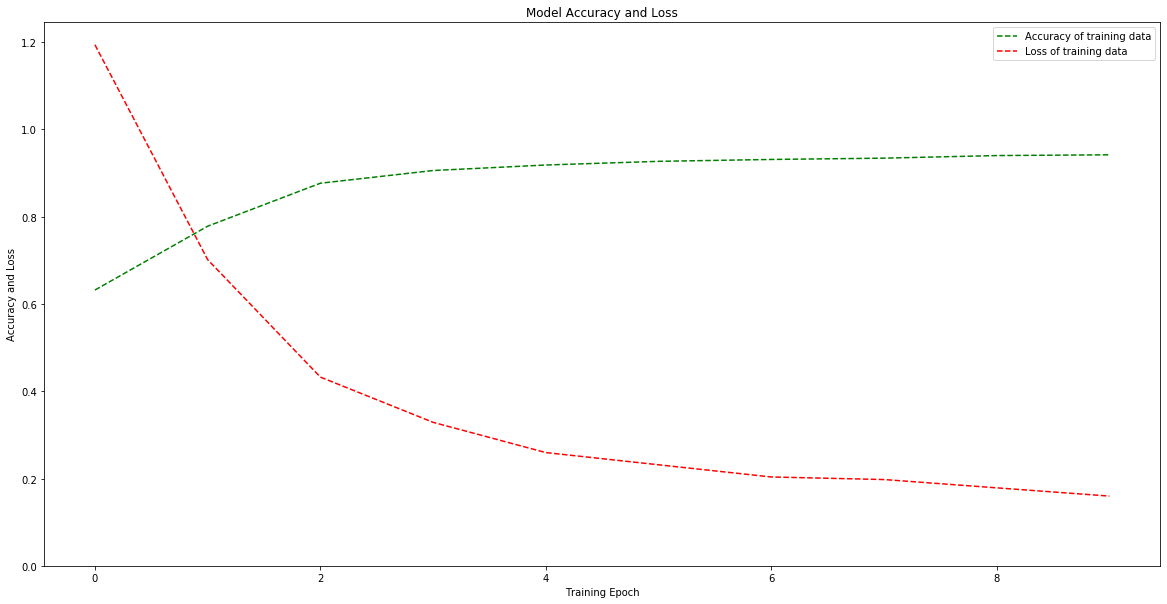

In [12]:
XX_train = np.asarray(X_train)
YY_train = np.asarray(Y_train)
XX_train = XX_train.astype("float32")
YY_train = YY_train.astype("float32")

XXX_train = feature_normalize(XX_train)

YY_train = to_categorical(YY_train, num_classes)

print("\n--- Fit the model ---\n")

# Hyper-parameters
BATCH_SIZE = 20
EPOCHS = 10

history = model.fit(XXX_train,
                      YY_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1)  

model.save_weights(model_weights_path)


print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(20, 10)) 
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
#model.save(model_save_path)